# setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Fitbuddy_Susanket/csv_with_lib/lunges/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# imports

In [ ]:
#!pip install scikit-multilearn

In [ ]:
#basic
import pandas as pd
import numpy as np
import math
import sys
from collections import Counter
import pickle
import os
from os import walk

#plots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import colorsys

#sklearn for pre-processing
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

#scores
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix
from sklearn.metrics import mean_squared_error

# using Label Powerset
#from skmultilearn.problem_transform import LabelPowerset
#from skmultilearn.problem_transform import BinaryRelevance

from imblearn.over_sampling import SMOTE

#classification
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

#stop warnings
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Functions

In [ ]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    #https://stackoverflow.com/a/57013458/8475746
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        y_2 = np.array(means_train[best_index])
        ax[i].errorbar(x, y_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())

    plt.legend()
    plt.show()

In [ ]:
def all_scores(y_true,y_pred):
  print('.'*20)
  print('all scores')
  s1 = f1_score(y_true = y_true, y_pred = y_pred)
  print('F1 Score on test: ' + str(s1))
  s1 = f1_score(y_true = y_true, y_pred = y_pred,average='micro')
  print('micro F1 Score on test: ' + str(s1))
  s2 = f1_score(y_true = y_true, y_pred = y_pred,average='macro')
  print('macro F1 Score on test: ' + str(s2))
  s3 = f1_score(y_true = y_true, y_pred = y_pred,average='weighted')
  print('weighted F1 Score on test: ' + str(s3))
  s4 = confusion_matrix(y_true, y_pred)
  print('confusion matrix:', str(s4))
  return s1,s2,s3,s4

In [ ]:
def store_model(model,model_file_nm):
  filename = path+'models/'+model_file_nm+'.sav'
  pickle.dump(model, open(filename, 'wb'))

# Classification

## Penalized SVM

In [ ]:
def penalized_svm_classifier(scaler,x,y,x_test,y_test,score,save_model,fd_name):
    X_tr_norm = scaler.transform(x)
    X_ts_norm = scaler.transform(x_test)

    c_val = np.arange(1, 100, 2)
    degree = [3,4,5,6]

    parameters = [{'kernel':['linear'], 'C':c_val},
                  {'kernel':['rbf','sigmoid'], 'C':c_val},
                  {'kernel':['poly'], 'C':c_val, 'degree':degree}]
    
    svc = SVC(class_weight='balanced', probability=True)
    clf = GridSearchCV(svc, parameters,cv = 5,return_train_score = True,scoring = 'f1')#_{}'.format(score))
    clf.fit(X_tr_norm, y)
    
    #plot_search_results(clf)
    print('best parameters : '+str(clf.best_params_))
    
    y_pred = clf.predict(X_ts_norm)

    s1,s2,s3,s4 = all_scores(y_test.copy(),y_pred.copy())
    
    if save_model:
      store_model(clf,fd_name+'/penalized_SVM')

    return s1,s2,s3,s4

## SVM

In [ ]:
def svm_classifier(scaler,x,y,x_test,y_test,score,save_model,fd_name,smote):
    X_tr_norm = scaler.transform(x)
    X_ts_norm = scaler.transform(x_test)

    c_val = np.arange(1, 100, 2)
    degree = [3,4,5,6]

    parameters = [{'kernel':['linear'], 'C':c_val},
                  {'kernel':['rbf','sigmoid'], 'C':c_val},
                  {'kernel':['poly'], 'C':c_val, 'degree':degree}]
    
    svc = SVC()
    clf = GridSearchCV(svc, parameters,cv = 5,return_train_score = True,scoring = 'f1')#_{}'.format(score))
    clf.fit(X_tr_norm, y)
    
    #plot_search_results(clf)
    print('best parameters : '+str(clf.best_params_))
    
    y_pred = clf.predict(X_ts_norm)

    s1,s2,s3,s4 = all_scores(y_test.copy(),y_pred.copy())
    
    if save_model:
      if smote:
        store_model(clf,fd_name+'/SVM_smote')
      else:
        store_model(clf,fd_name+'/SVM')

    return s1,s2,s3,s4

## LDA

In [ ]:
def lda_classifier(scaler,x,y,x_test,y_test,score,save_model,fd_name,smote):
    X_tr_norm = scaler.transform(x)
    X_ts_norm = scaler.transform(x_test)
    
    shrinkage_val = np.arange(0.0, 0.99, 0.01)
    parameters = [{'solver':['lsqr'],'shrinkage' :shrinkage_val}, {'solver' : ['svd']}]
    
    lda = LinearDiscriminantAnalysis()
    clf = GridSearchCV(lda, parameters,cv = 5,return_train_score = True, scoring = 'f1')#_'+score)
    clf.fit(X_tr_norm, y)
    
    print('best parameters : '+str(clf.best_params_))
    
    y_pred = clf.predict(X_ts_norm)
    
    s1,s2,s3,s4 = all_scores(y_test,y_pred)

    if save_model:
      if smote:
        store_model(clf, fd_name+'/lda_smote')
      else:
        store_model(clf, fd_name+'/lda')

    return s1,s2,s3,s4

## KNN Classifier

In [ ]:
def knn_classifier(scaler,x,y,x_test,y_test,score,save_model,fd_name,smote):
    X_tr_norm = scaler.transform(x)
    X_ts_norm = scaler.transform(x_test)
    
    k_val = np.arange(1, 20, 1)
    parameters = {'n_neighbors':k_val, 'weights':('uniform', 'distance')}

    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, parameters,cv = 5,return_train_score = True, scoring = 'f1')#_'+score)
    clf.fit(X_tr_norm, y)
    plot_search_results(clf)
    print('best parameters : '+str(clf.best_params_))
    
    y_pred = clf.predict(X_ts_norm)

    s1,s2,s3,s4 = all_scores(y_test,y_pred)

    if save_model:
      if smote:
        store_model(clf,fd_name+'/KNN_smote')
      else:
        store_model(clf,fd_name+'/KNN')

    return s1,s2,s3,s4

## Random Forest

In [ ]:
from sklearn.base import ClassifierMixin
def rand_forest_classifier(scaler,x,y,x_test,y_test,score,save_model,fd_name,smote):
    X_tr_norm = scaler.transform(x)
    X_ts_norm = scaler.transform(x_test)

    n_val = np.arange(10, 200, 5)
    max_val = np.arange(2, 10, 1)
    parameters = {'n_estimators':n_val, 'criterion':('gini', 'entropy'),'max_depth':max_val}

    rf = RandomForestClassifier()
    clf = GridSearchCV(rf, parameters,cv = 5,return_train_score = True, scoring = 'f1')#_'+score)
    clf.fit(X_tr_norm, y)
    plot_search_results(clf)
    print('best parameters : '+str(clf.best_params_))
    
    y_pred = clf.predict(X_ts_norm)
    

    s1,s2,s3,s4 = all_scores(y_test,y_pred)

    if save_model:
      if smote:
        store_model(clf,fd_name+'/randomforest_smote')
      else:
        store_model(clf,fd_name+'/randomforest')

    return s1,s2,s3,s4

# run function

In [ ]:
def write_scores(file_name,s,end):
    file = open(r''+path+'results/'+file_name+'.csv', 'a')
    file.write(s)
    if end:
        file.write('\n')
    else:
        file.write(',')
    file.close()

In [ ]:
def label(s):
    print('-'*100)
    print(s)

In [ ]:
def classify(file_name,x,y,save_model):
    print('stats of classes {}'.format(Counter(y)))

    train_x,test_x, train_y, test_y = train_test_split(x,y,test_size = 0.2,random_state=42)

    print('size of Train set: {}\nsize of test set: {}'.format(len(train_y),len(test_y)))
    print('stats of train classes {}'.format(Counter(train_y)))
    print('stats of test classes {}'.format(Counter(test_y)))
  
    
    #creating a file if not exists otherwise cleaning it.
    file = open(r''+path+'new_results/'+file_name+'.csv', 'w')
    file.write('models,f1_micro,f1_macro,f1_weighted\n')
    file.close()

    if save_model:
      # checks if folder for storing model exists
      if not os.path.isdir(path+'models/'+file_name+'/'):
        os.mkdir(path+'models/'+file_name+'/')
    

    smote = SMOTE()

    train_x_smote,train_y_smote = smote.fit_resample(train_x,train_y)

    print('stats of smote train classes {}'.format(Counter(train_y_smote)))

    scaler = MinMaxScaler()
    scaler.fit(train_x)
    if save_model:
      store_model(scaler,file_name+'/scaler')

    label('penalized_svm')
    write_scores(file_name,'penalized_svm',False)
    s1,s2,s3,s4 = penalized_svm_classifier(scaler,train_x,train_y,test_x,test_y,'macro',save_model,file_name)
    write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)
    
    label('svm')
    write_scores(file_name,'SVM',False)
    s1,s2,s3,s4 = svm_classifier(scaler,train_x,train_y,test_x,test_y,'macro',save_model,file_name,False)
    write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)

    label('smote svm')
    write_scores(file_name,'smote SVM',False)
    s1,s2,s3,s4 = svm_classifier(scaler,train_x_smote,train_y_smote,test_x,test_y,'macro',save_model,file_name,True)
    write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)
    
    label('lda_classifier')
    write_scores(file_name,'lda_classifier',False)
    s1,s2,s3,s4 = lda_classifier(scaler,train_x,train_y,test_x,test_y,'macro',save_model,file_name,False)
    write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)

    label('smote lda_classifier')
    write_scores(file_name,'smote lda_classifier',False)
    s1,s2,s3,s4 = lda_classifier(scaler,train_x_smote,train_y_smote,test_x,test_y,'macro',save_model,file_name,True)
    write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)
    
    label('knn_classifier')
    write_scores(file_name,'knn_classifier',False)
    s1,s2,s3,s4 = knn_classifier(scaler,train_x,train_y,test_x,test_y,'macro',save_model,file_name,False)
    write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)

    label('smote knn_classifier')
    write_scores(file_name,'smote knn_classifier',False)
    s1,s2,s3,s4 = knn_classifier(scaler,train_x_smote,train_y_smote,test_x,test_y,'macro',save_model,file_name,True)
    write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)
    
    # label('rand_forest_classifier')
    # write_scores(file_name,'rand_forest_classifier',False)
    # s1,s2,s3,s4 = rand_forest_classifier(scaler,train_x,train_y,test_x,test_y,'macro',save_model,file_name,False)
    # write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)

    # label('smote rand_forest_classifier')
    # write_scores(file_name,'smote rand_forest_classifier',False)
    # s1,s2,s3,s4 = rand_forest_classifier(scaler,train_x_smote,train_y_smote,test_x,test_y,'macro',save_model,file_name,True)
    # write_scores(file_name,str(s1)+','+str(s2)+','+str(s3)+','+str(s4),True)

In [ ]:
def run(read_file_nm,result_file_nm,save_model,start_from,label_count):

  df = pd.read_csv(path+'data/'+read_file_nm+".csv", header = None)
  sep = df.shape[1]-label_count
  x = df[[i for i in range(sep)]].values.tolist()
  y = np.array(df[[i for i in range(sep,df.shape[1])]].values.tolist())


  label('multilabel classify')
  for i in range(start_from,y.shape[1]):
    label("label_"+str(i))
    classify("label_"+str(i)+"_"+result_file_nm,x.copy(),y[:,i].copy(),save_model)

# main

## corrected dataset training

----------------------------------------------------------------------------------------------------
multilabel classify
----------------------------------------------------------------------------------------------------
label_0
stats of classes Counter({0: 279, 1: 119})
size of Train set: 318
size of test set: 80
stats of train classes Counter({0: 222, 1: 96})
stats of test classes Counter({0: 57, 1: 23})
stats of smote train classes Counter({0: 222, 1: 222})
----------------------------------------------------------------------------------------------------
penalized_svm
best parameters : {'C': 3, 'kernel': 'rbf'}
....................
all scores
F1 Score on test: 0.5957446808510638
micro F1 Score on test: 0.7625
macro F1 Score on test: 0.7138015439653549
weighted F1 Score on test: 0.7639757107889287
confusion matrix: [[47 10]
 [ 9 14]]
----------------------------------------------------------------------------------------------------
svm
best parameters : {'C': 63, 'kernel': 'linea

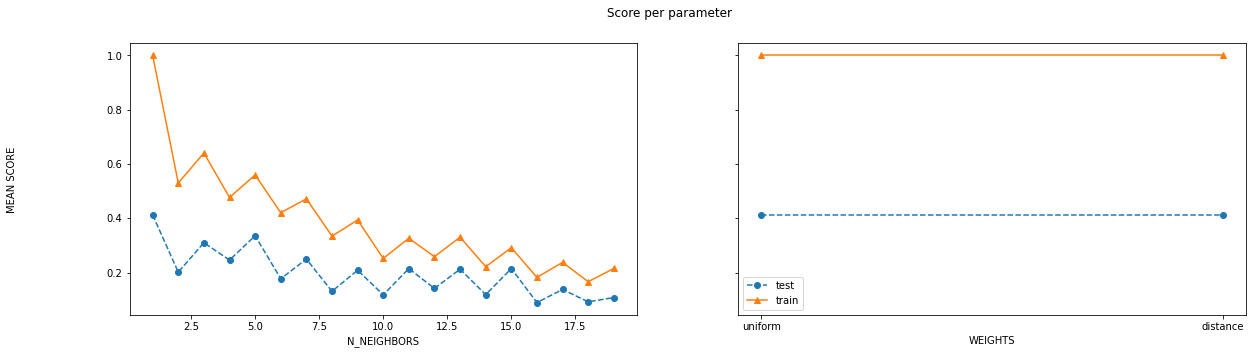

best parameters : {'n_neighbors': 1, 'weights': 'uniform'}
....................
all scores
F1 Score on test: 0.5116279069767442
micro F1 Score on test: 0.7375
macro F1 Score on test: 0.6660703637447823
weighted F1 Score on test: 0.7317084078711986
confusion matrix: [[48  9]
 [12 11]]
----------------------------------------------------------------------------------------------------
smote knn_classifier


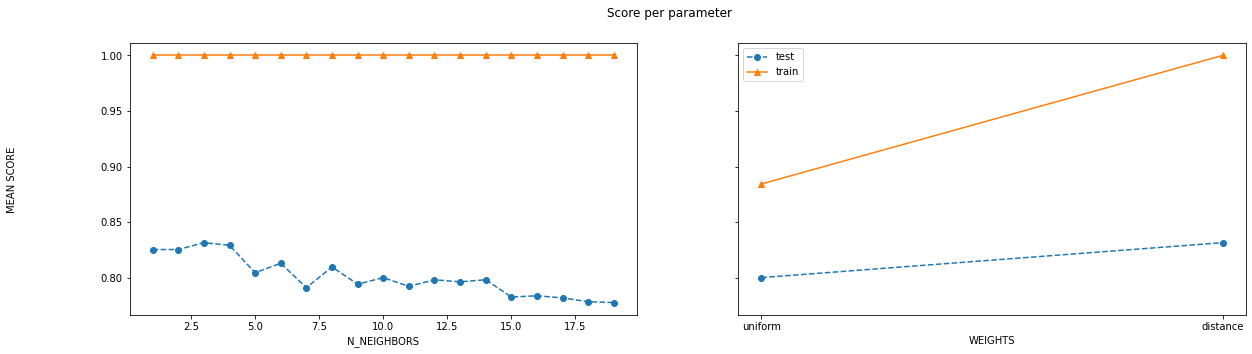

best parameters : {'n_neighbors': 3, 'weights': 'distance'}
....................
all scores
F1 Score on test: 0.5555555555555556
micro F1 Score on test: 0.7
macro F1 Score on test: 0.6645702306079664
weighted F1 Score on test: 0.7109014675052411
confusion matrix: [[41 16]
 [ 8 15]]
----------------------------------------------------------------------------------------------------
label_1
stats of classes Counter({0: 245, 1: 153})
size of Train set: 318
size of test set: 80
stats of train classes Counter({0: 194, 1: 124})
stats of test classes Counter({0: 51, 1: 29})
stats of smote train classes Counter({0: 194, 1: 194})
----------------------------------------------------------------------------------------------------
penalized_svm
best parameters : {'C': 1, 'kernel': 'sigmoid'}
....................
all scores
F1 Score on test: 0.5797101449275363
micro F1 Score on test: 0.6375
macro F1 Score on test: 0.6305144131231089
weighted F1 Score on test: 0.6444855868768913
confusion matrix: [

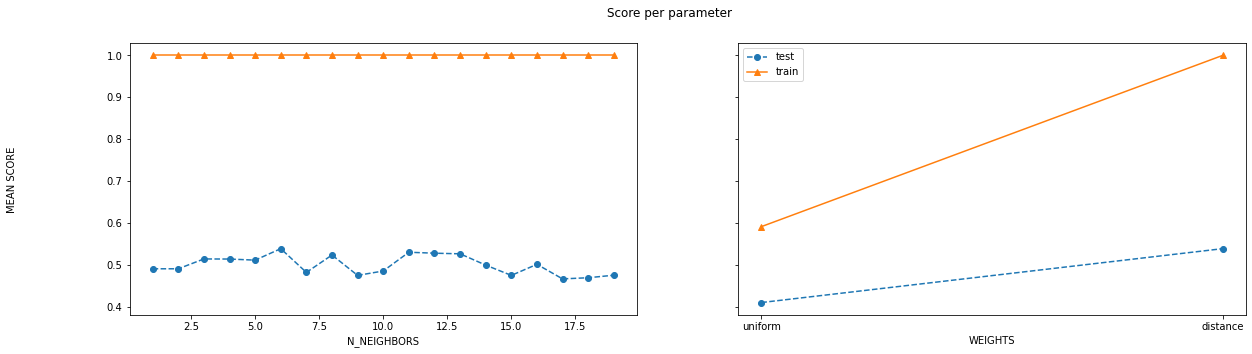

best parameters : {'n_neighbors': 6, 'weights': 'distance'}
....................
all scores
F1 Score on test: 0.3880597014925373
micro F1 Score on test: 0.4875
macro F1 Score on test: 0.4735997432193869
weighted F1 Score on test: 0.4971232546942705
confusion matrix: [[26 25]
 [16 13]]
----------------------------------------------------------------------------------------------------
smote knn_classifier


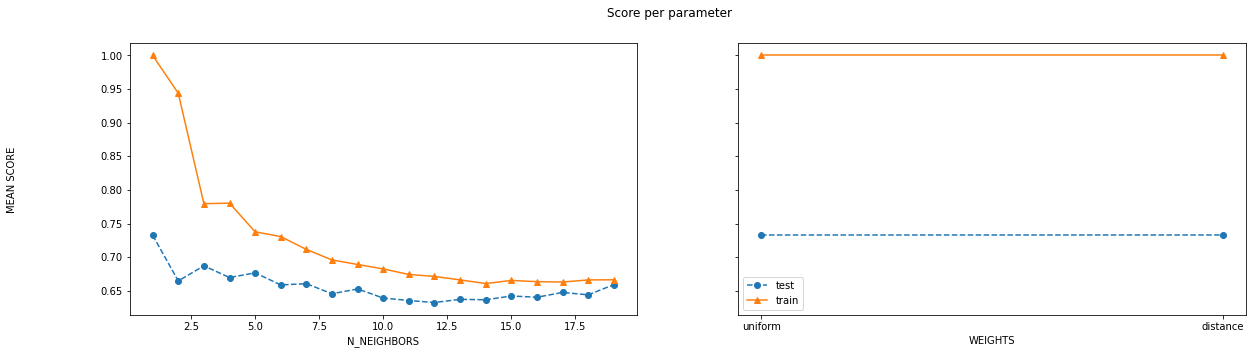

best parameters : {'n_neighbors': 1, 'weights': 'uniform'}
....................
all scores
F1 Score on test: 0.4383561643835616
micro F1 Score on test: 0.4875
macro F1 Score on test: 0.48354589828373484
weighted F1 Score on test: 0.49597307510628247
confusion matrix: [[23 28]
 [13 16]]
----------------------------------------------------------------------------------------------------
label_2
stats of classes Counter({0: 326, 1: 72})
size of Train set: 318
size of test set: 80
stats of train classes Counter({0: 262, 1: 56})
stats of test classes Counter({0: 64, 1: 16})
stats of smote train classes Counter({1: 262, 0: 262})
----------------------------------------------------------------------------------------------------
penalized_svm
best parameters : {'C': 5, 'kernel': 'sigmoid'}
....................
all scores
F1 Score on test: 0.46153846153846156
micro F1 Score on test: 0.65
macro F1 Score on test: 0.6011396011396011
weighted F1 Score on test: 0.6849002849002848
confusion matrix: 

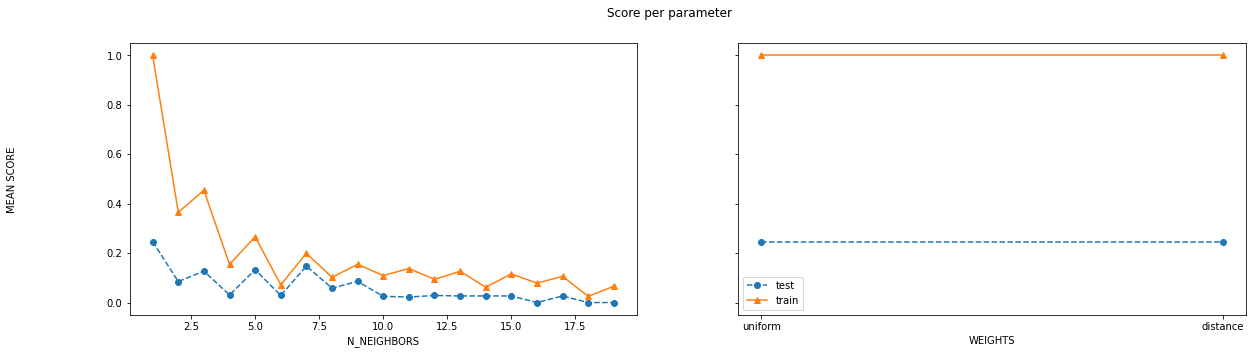

best parameters : {'n_neighbors': 1, 'weights': 'uniform'}
....................
all scores
F1 Score on test: 0.22222222222222224
micro F1 Score on test: 0.65
macro F1 Score on test: 0.49820788530465954
weighted F1 Score on test: 0.663799283154122
confusion matrix: [[48 16]
 [12  4]]
----------------------------------------------------------------------------------------------------
smote knn_classifier


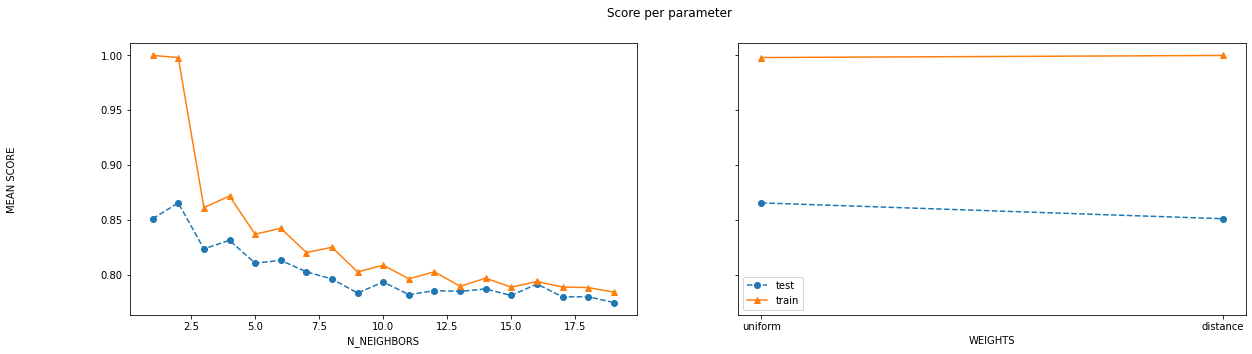

best parameters : {'n_neighbors': 2, 'weights': 'uniform'}
....................
all scores
F1 Score on test: 0.2978723404255319
micro F1 Score on test: 0.5875
macro F1 Score on test: 0.5029184710977217
weighted F1 Score on test: 0.6259461495010357
confusion matrix: [[40 24]
 [ 9  7]]
----------------------------------------------------------------------------------------------------
label_3
stats of classes Counter({0: 344, 1: 54})
size of Train set: 318
size of test set: 80
stats of train classes Counter({0: 276, 1: 42})
stats of test classes Counter({0: 68, 1: 12})
stats of smote train classes Counter({0: 276, 1: 276})
----------------------------------------------------------------------------------------------------
penalized_svm
best parameters : {'C': 1, 'kernel': 'rbf'}
....................
all scores
F1 Score on test: 0.22222222222222224
micro F1 Score on test: 0.7375
macro F1 Score on test: 0.5321637426900585
weighted F1 Score on test: 0.749122807017544
confusion matrix: [[56 

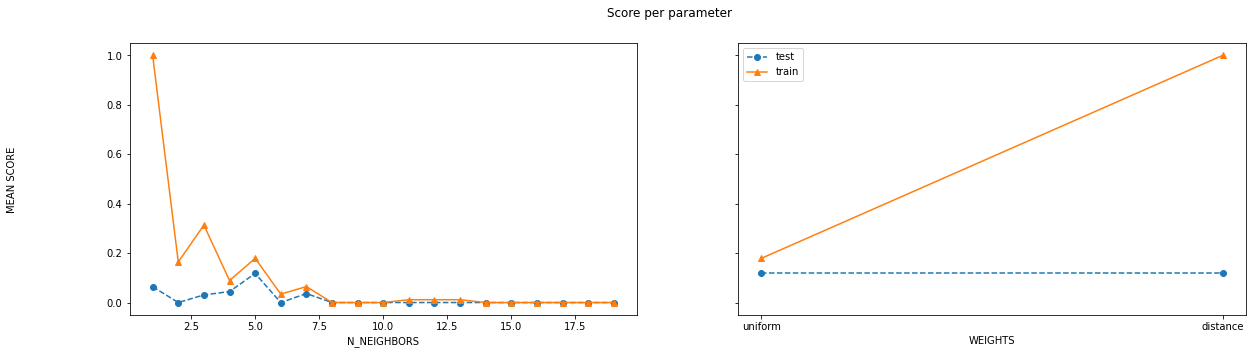

best parameters : {'n_neighbors': 5, 'weights': 'uniform'}
....................
all scores
F1 Score on test: 0.0
micro F1 Score on test: 0.8375
macro F1 Score on test: 0.45578231292517
weighted F1 Score on test: 0.774829931972789
confusion matrix: [[67  1]
 [12  0]]
----------------------------------------------------------------------------------------------------
smote knn_classifier


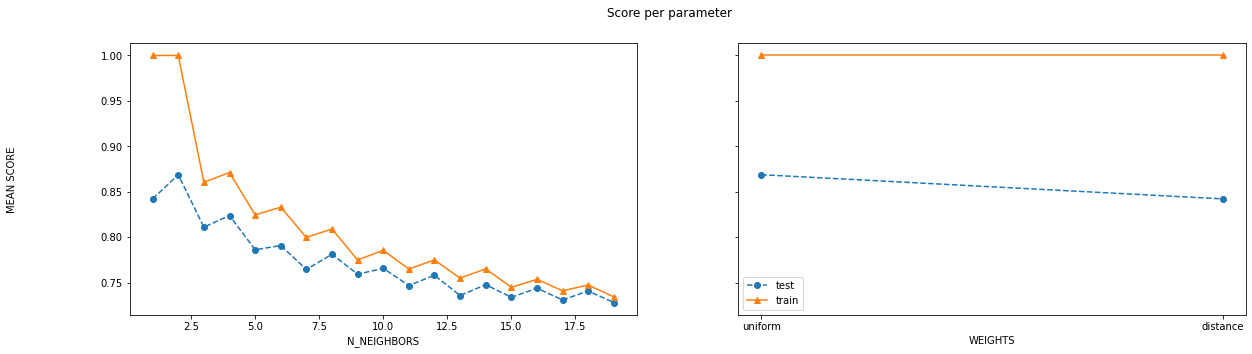

best parameters : {'n_neighbors': 2, 'weights': 'uniform'}
....................
all scores
F1 Score on test: 0.18181818181818182
micro F1 Score on test: 0.55
macro F1 Score on test: 0.4357366771159875
weighted F1 Score on test: 0.6134796238244514
confusion matrix: [[40 28]
 [ 8  4]]


In [ ]:
run(read_file_nm = '10003', result_file_nm = 'multilabel_results',save_model = True, start_from = 0, label_count = 4)